In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np

In [2]:
comp=sb.competitions()
comp[comp['competition_id']==55]

/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
68,55,282,Europe,UEFA Euro,male,False,True,2024,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,2024-07-15T15:52:24.778809,2024-07-15T15:48:50.315500
69,55,43,Europe,UEFA Euro,male,False,True,2020,2024-04-16T12:44:40.558402,2024-04-16T12:47:18.505110,2024-04-16T12:47:18.505110,2024-04-16T12:44:40.558402


In [3]:
match=sb.matches(competition_id=55,season_id=282)

/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [4]:
spain_match=match[(match['home_team']=='Spain') | (match['away_team']=='Spain')]
spain_match=spain_match[['match_id','home_team', 'away_team', 'home_score', 'away_score','competition_stage']]

In [5]:
spain_match_ids=list(spain_match['match_id'])
spain_match_ids_dict=spain_match.groupby('competition_stage')['match_id'].apply(list).to_dict()

In [6]:
final_spain=spain_match_ids_dict['Final']

In [7]:
prior_ids=set(spain_match_ids)
prior_ids=list(prior_ids)

In [8]:
prior_match_event = pd.DataFrame() 

for i in prior_ids:
    match_event = sb.events(match_id=i)
    prior_match_event = pd.concat([prior_match_event, match_event], ignore_index=True)


/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/st

In [9]:
prior_match_pass=prior_match_event[prior_match_event['type']=='Pass']

In [10]:
prior_match_xp=prior_match_pass[['location','pass_body_part','match_id','minute','under_pressure','pass_end_location','pass_outcome','pass_type','possession_team','team','type',]]

In [11]:
prior_match_xp['under_pressure'].fillna(False,inplace=True)
prior_match_xp['pass_type'].fillna('Normal Pass',inplace=True)
prior_match_xp['pass_outcome'].fillna(1,inplace=True)

/var/folders/w1/v_96k9nn4k73369wp7ddnydw0000gn/T/ipykernel_23770/1329283562.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prior_match_xp['under_pressure'].fillna(False,inplace=True)
/var/folders/w1/v_96k9nn4k73369wp7ddnydw0000gn/T/ipykernel_23770/1329283562.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)

In [12]:
prior_match_xp=prior_match_xp[prior_match_xp['possession_team']==prior_match_xp['team']]
prior_match_xp=prior_match_xp[prior_match_xp.team=='Spain']

In [13]:
# Function to convert lists to tuples, leave other types unchanged
def convert_to_tuple(x):
    if isinstance(x, list):
        return tuple(x)
    return x

prior_match_xp['pass_end_location'] = prior_match_xp['pass_end_location'].apply(convert_to_tuple)
prior_match_xp['location'] = prior_match_xp['location'].apply(convert_to_tuple)

# Extract x, y, endx, endy coordinates
prior_match_xp['x'] = prior_match_xp['location'].apply(lambda loc: loc[0])
prior_match_xp['endx'] = prior_match_xp['pass_end_location'].apply(lambda loc: loc[0])
prior_match_xp['y'] = prior_match_xp['location'].apply(lambda loc: loc[1])
prior_match_xp['endy'] = prior_match_xp['pass_end_location'].apply(lambda loc: loc[1])


In [14]:
prior_match_xp['box_start'] = np.where((prior_match_xp.x < 20) & (prior_match_xp.y < 20), 1,
                                          np.where((prior_match_xp.x < 20) & (prior_match_xp.y >= 20) & (prior_match_xp.y < 40), 2,
                                                   np.where((prior_match_xp.x < 20) & (prior_match_xp.y >= 40) & (prior_match_xp.y < 60), 3,
                                                            np.where((prior_match_xp.x < 20) & (prior_match_xp.y >= 60), 4,
                                                                     np.where((prior_match_xp.x >= 20) & (prior_match_xp.x < 40) & (prior_match_xp.y < 20), 5,
                                                                              np.where((prior_match_xp.x >= 20) & (prior_match_xp.x < 40) & (prior_match_xp.y >= 20) & (prior_match_xp.y < 40), 6,
                                                                                       np.where((prior_match_xp.x >= 20) & (prior_match_xp.x < 40) & (prior_match_xp.y >= 40) & (prior_match_xp.y < 60), 7,
                                                                                                np.where((prior_match_xp.x >= 20) & (prior_match_xp.x < 40) & (prior_match_xp.y >= 60), 8,
                                                                                                         np.where((prior_match_xp.x >= 40) & (prior_match_xp.x < 60) & (prior_match_xp.y < 20), 9,
                                                                                                                  np.where((prior_match_xp.x >= 40) & (prior_match_xp.x < 60) & (prior_match_xp.y >= 20) & (prior_match_xp.y < 40), 10,
                                                                                                                           np.where((prior_match_xp.x >= 40) & (prior_match_xp.x < 60) & (prior_match_xp.y >= 40) & (prior_match_xp.y < 60), 11,
                                                                                                                                    np.where((prior_match_xp.x >= 40) & (prior_match_xp.x < 60) & (prior_match_xp.y >= 60), 12,
                                                                                                                                             np.where((prior_match_xp.x >= 60) & (prior_match_xp.x < 80) & (prior_match_xp.y < 20), 13,
                                                                                                                                                      np.where((prior_match_xp.x >= 60) & (prior_match_xp.x < 80) & (prior_match_xp.y >= 20) & (prior_match_xp.y < 40), 14,
                                                                                                                                                               np.where((prior_match_xp.x >= 60) & (prior_match_xp.x < 80) & (prior_match_xp.y >= 40) & (prior_match_xp.y < 60), 15,
                                                                                                                                                                        np.where((prior_match_xp.x >= 60) & (prior_match_xp.x < 80) & (prior_match_xp.y >= 60), 16,
                                                                                                                                                                                 np.where((prior_match_xp.x >= 80) & (prior_match_xp.x < 100) & (prior_match_xp.y < 20), 17,
                                                                                                                                                                                          np.where((prior_match_xp.x >= 80) & (prior_match_xp.x < 100) & (prior_match_xp.y >= 20) & (prior_match_xp.y < 40), 18,
                                                                                                                                                                                                   np.where((prior_match_xp.x >= 80) & (prior_match_xp.x < 100) & (prior_match_xp.y >= 40) & (prior_match_xp.y < 60), 19,
                                                                                                                                                                                                            np.where((prior_match_xp.x >= 80) & (prior_match_xp.x < 100) & (prior_match_xp.y >= 60), 20,
                                                                                                                                                                                                                     np.where((prior_match_xp.x >= 100) & (prior_match_xp.y < 20), 21,
                                                                                                                                                                                                                              np.where((prior_match_xp.x >= 100) & (prior_match_xp.y >= 20) & (prior_match_xp.y < 40), 22,
                                                                                                                                                                                                                                       np.where((prior_match_xp.x >= 100) & (prior_match_xp.y >= 40) & (prior_match_xp.y < 60), 23,
                                                                                                                                                                                                                                                np.where((prior_match_xp.x >= 100) & (prior_match_xp.y >= 60), 24,
                                                                                                                                                                                                                                                         0)))))))))))))))))))))))) 

# Display the DataFrame to check the result
prior_match_xp['box_end'] = np.where((prior_match_xp.endx < 20) & (prior_match_xp.endy < 20), 1,
                                          np.where((prior_match_xp.endx < 20) & (prior_match_xp.endy >= 20) & (prior_match_xp.endy < 40), 2,
                                                   np.where((prior_match_xp.endx < 20) & (prior_match_xp.endy >= 40) & (prior_match_xp.endy < 60), 3,
                                                            np.where((prior_match_xp.endx < 20) & (prior_match_xp.endy >= 60), 4,
                                                                     np.where((prior_match_xp.endx >= 20) & (prior_match_xp.endx < 40) & (prior_match_xp.endy < 20), 5,
                                                                              np.where((prior_match_xp.endx >= 20) & (prior_match_xp.endx < 40) & (prior_match_xp.endy >= 20) & (prior_match_xp.endy < 40), 6,
                                                                                       np.where((prior_match_xp.endx >= 20) & (prior_match_xp.endx < 40) & (prior_match_xp.endy >= 40) & (prior_match_xp.endy < 60), 7,
                                                                                                np.where((prior_match_xp.endx >= 20) & (prior_match_xp.endx < 40) & (prior_match_xp.endy >= 60), 8,
                                                                                                         np.where((prior_match_xp.endx >= 40) & (prior_match_xp.endx < 60) & (prior_match_xp.endy < 20), 9,
                                                                                                                  np.where((prior_match_xp.endx >= 40) & (prior_match_xp.endx < 60) & (prior_match_xp.endy >= 20) & (prior_match_xp.endy < 40), 10,
                                                                                                                           np.where((prior_match_xp.endx >= 40) & (prior_match_xp.endx < 60) & (prior_match_xp.endy >= 40) & (prior_match_xp.endy < 60), 11,
                                                                                                                                    np.where((prior_match_xp.endx >= 40) & (prior_match_xp.endx < 60) & (prior_match_xp.endy >= 60), 12,
                                                                                                                                             np.where((prior_match_xp.endx >= 60) & (prior_match_xp.endx < 80) & (prior_match_xp.endy < 20), 13,
                                                                                                                                                      np.where((prior_match_xp.endx >= 60) & (prior_match_xp.endx < 80) & (prior_match_xp.endy >= 20) & (prior_match_xp.endy < 40), 14,
                                                                                                                                                               np.where((prior_match_xp.endx >= 60) & (prior_match_xp.endx < 80) & (prior_match_xp.endy >= 40) & (prior_match_xp.endy < 60), 15,
                                                                                                                                                                        np.where((prior_match_xp.endx >= 60) & (prior_match_xp.endx < 80) & (prior_match_xp.endy >= 60), 16,
                                                                                                                                                                                 np.where((prior_match_xp.endx >= 80) & (prior_match_xp.endx < 100) & (prior_match_xp.endy < 20), 17,
                                                                                                                                                                                          np.where((prior_match_xp.endx >= 80) & (prior_match_xp.endx < 100) & (prior_match_xp.endy >= 20) & (prior_match_xp.endy < 40), 18,
                                                                                                                                                                                                   np.where((prior_match_xp.endx >= 80) & (prior_match_xp.endx < 100) & (prior_match_xp.endy >= 40) & (prior_match_xp.endy < 60), 19,
                                                                                                                                                                                                            np.where((prior_match_xp.endx >= 80) & (prior_match_xp.endx < 100) & (prior_match_xp.endy >= 60), 20,
                                                                                                                                                                                                                     np.where((prior_match_xp.endx >= 100) & (prior_match_xp.endy < 20), 21,
                                                                                                                                                                                                                              np.where((prior_match_xp.endx >= 100) & (prior_match_xp.endy >= 20) & (prior_match_xp.endy < 40), 22,
                                                                                                                                                                                                                                       np.where((prior_match_xp.endx >= 100) & (prior_match_xp.endy >= 40) & (prior_match_xp.endy < 60), 23,
                                                                                                                                                                                                                                                np.where((prior_match_xp.endx >= 100) & (prior_match_xp.endy >= 60), 24,
                                                                                                                                                                                                                                                         0)))))))))))))))))))))))) 

# Display the DataFrame to check the result

In [15]:
prior_match_xp['Normal Pass']=np.where(prior_match_xp['pass_type']=='Normal Pass',1,0)
prior_match_xp['Leg Pass'] = np.where(
    (prior_match_xp['pass_body_part'] == 'Right Foot') | 
    (prior_match_xp['pass_body_part'] == 'Left Foot'), 
    1, 0
)
prior_match_xp['Under Pressure']=prior_match_xp['under_pressure'].astype(int)
prior_match_xp['Pass Outcome']=np.where(prior_match_xp['pass_outcome']==1,1,0)
prior_match_xp

,location,pass_body_part,match_id,minute,under_pressure,pass_end_location,pass_outcome,pass_type,possession_team,team,...,x,endx,y,endy,box_start,box_end,Normal Pass,Leg Pass,Under Pressure,Pass Outcome
11,"(69.3, 12.4)",Right Foot,3942752,0,False,"(64.0, 11.1)",1,Normal Pass,Spain,Spain,...,69.3,64.0,12.4,11.1,13,13,1,1,0,1
12,"(64.2, 12.0)",Left Foot,3942752,0,False,"(64.3, 31.0)",1,Normal Pass,Spain,Spain,...,64.2,64.3,12.0,31.0,13,14,1,1,0,1
19,"(68.7, 80.0)",NaN,3942752,0,False,"(76.7, 69.5)",1,Throw-in,Spain,Spain,...,68.7,76.7,80.0,69.5,16,16,0,0,0,1
20,"(75.9, 69.7)",Right Foot,3942752,0,False,"(70.9, 77.7)",1,Normal Pass,Spain,Spain,...,75.9,70.9,69.7,77.7,16,16,1,1,0,1
21,"(70.9, 77.7)",Right Foot,3942752,0,False,"(37.3, 38.8)",1,Normal Pass,Spain,Spain,...,70.9,37.3,77.7,38.8,16,6,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23713,"(13.6, 46.4)",Right Foot,3930172,94,True,"(18.1, 26.1)",1,Normal Pass,Spain,Spain,...,13.6,18.1,46.4,26.1,3,2,1,1,1,1
23714,"(21.6, 24.7)",Left Foot,3930172,94,False,"(81.1, 47.2)",Incomplete,Normal Pass,Spain,Spain,...,21.6,81.1,24.7,47.2,6,19,1,1,0,0
23722,"(21.6, 15.8)",Head,3930172,94,False,"(31.0, 13.2)",1,Interception,Spain,Spain,...,21.6,31.0,15.8,13.2,5,5,0,0,0,1
23723,"(31.0, 13.2)",Right Foot,3930172,94,False,"(37.6, 25.9)",1,Normal Pass,Spain,Spain,...,31.0,37.6,13.2,25.9,5,6,1,1,0,1


In [16]:
prior_match_xp['pass_body_part'].value_counts()

pass_body_part
Right Foot    2226
Left Foot     1674
Head            96
Keeper Arm      35
Other           18
No Touch         5
Drop Kick        5
Name: count, dtype: int64

In [17]:
reg_xp=prior_match_xp[['match_id', 'minute','x', 'endx', 'y', 'endy', 'box_start', 'box_end','Normal Pass', 'Leg Pass', 'Under Pressure', 'Pass Outcome']]

In [18]:
train_xp=reg_xp[reg_xp.match_id!=3943043]
test_xp=reg_xp[reg_xp.match_id==3943043]

 type 1

In [20]:
features = ['box_start', 'box_end', 'Normal Pass', 'Leg Pass', 'Under Pressure']
target = 'Pass Outcome'

X = train_xp[features]
y = train_xp[target]

In [21]:
X_standardized = (X - X.mean()) / X.std()

In [22]:
import pymc as pm

In [23]:
with pm.Model() as logistic_model:
    # Priors for coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coefs = pm.Normal('coefs', mu=0, sigma=10, shape=X_standardized.shape[1])
    
    # Linear combination
    logits = intercept + pm.math.dot(X_standardized.values, coefs)
    
    # Likelihood
    outcome = pm.Bernoulli('outcome', logit_p=logits, observed=y)
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coefs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'coefs\n0'}>,
        <Axes: title={'center': 'coefs\n1'}>],
       [<Axes: title={'center': 'coefs\n2'}>,
        <Axes: title={'center': 'coefs\n3'}>,
        <Axes: title={'center': 'coefs\n4'}>]], dtype=object)

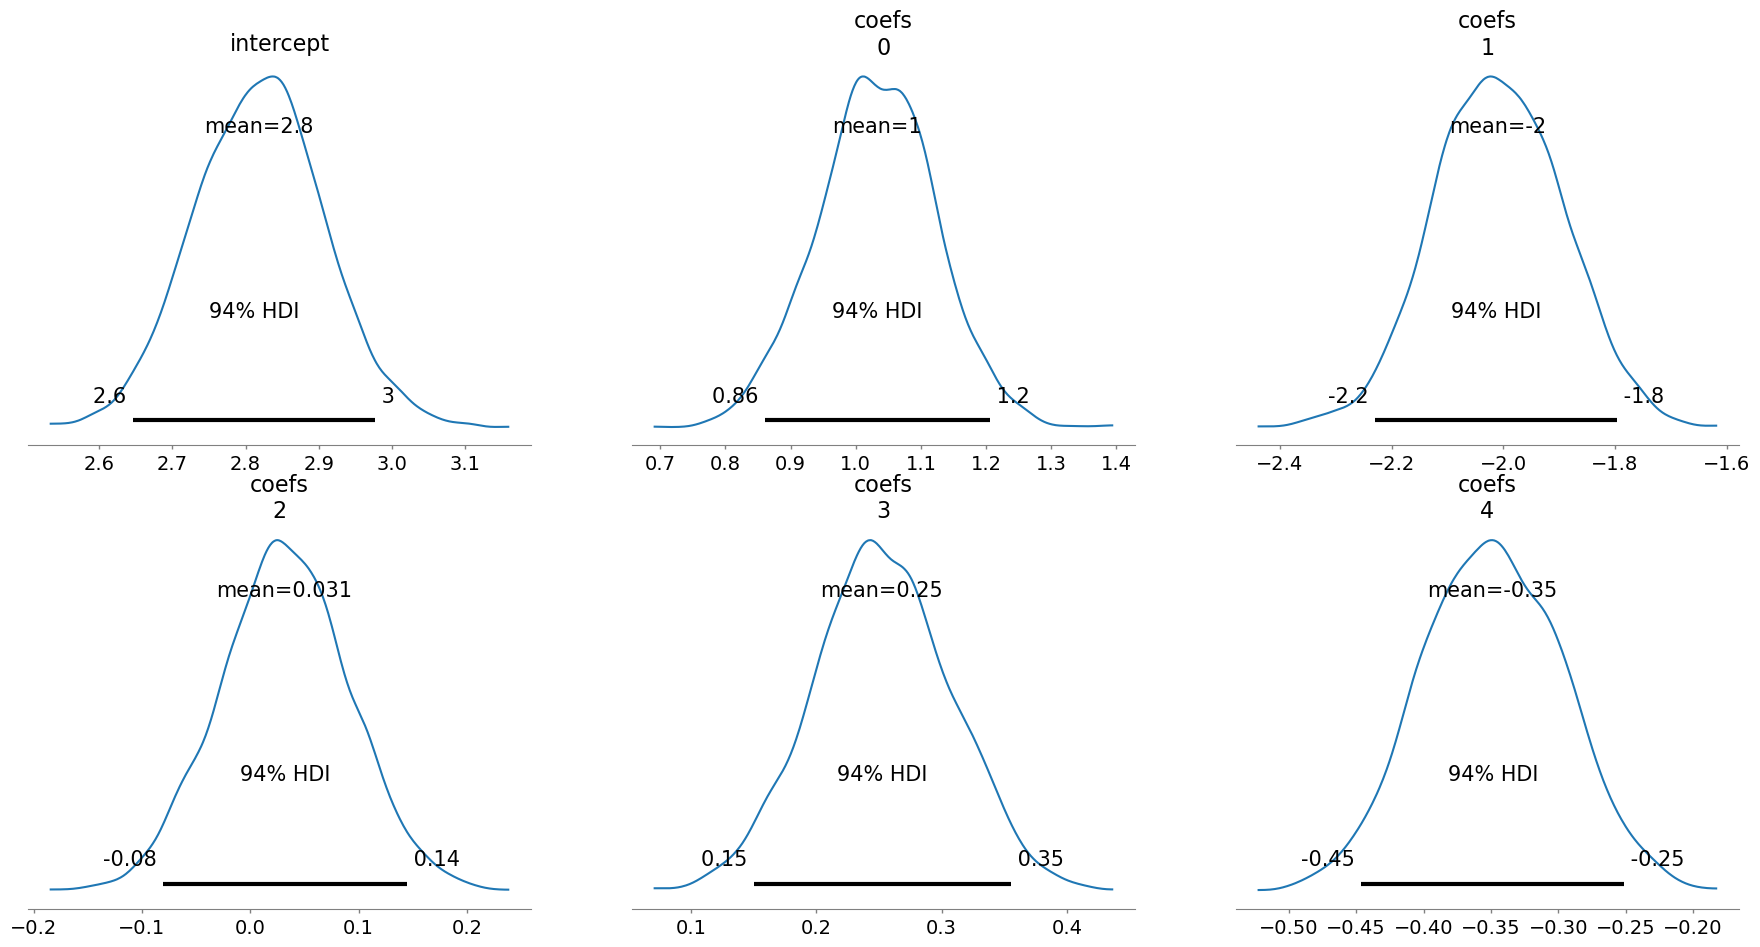

In [24]:
import arviz as az
az.summary(trace, hdi_prob=0.95)
az.plot_posterior(trace)

| Coef Index | Feature          | Mean      | 94% HDI         | Interpretation                                                                 |
| ---------- | ---------------- | --------- | --------------- | ------------------------------------------------------------------------------ |
| intercept  | Intercept        | 2.8       | \[2.7, 3.0]     | Baseline log-odds of success when all features are zero (after standardizing). |
| coefs\[0]  | `box_start`      | **1.0**   | \[0.85, 1.2]    | **Positive** effect → further forward passes (start) increase pass success.    |
| coefs\[1]  | `box_end`        | **-2.0**  | \[-2.2, -1.8]   | **Strong negative** effect → passes ending further upfield reduce success.     |
| coefs\[2]  | `Normal Pass`    | \~0.03    | \[-0.08, 0.14]  | **Uncertain** effect → HDI includes 0, not clearly impactful.                  |
| coefs\[3]  | `Leg Pass`       | **0.25**  | \[0.15, 0.36]   | **Moderate positive** → leg passes increase pass success probability.          |
| coefs\[4]  | `Under Pressure` | **-0.35** | \[-0.45, -0.25] | **Significant negative** → being under pressure reduces pass success.          |


In [26]:
X_test = test_xp[features]
X_test_standardized = (X_test - X.mean()) / X.std()
y_test=test_xp[target]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coefs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'coefs\n0'}>,
        <Axes: title={'center': 'coefs\n1'}>],
       [<Axes: title={'center': 'coefs\n2'}>,
        <Axes: title={'center': 'coefs\n3'}>,
        <Axes: title={'center': 'coefs\n4'}>]], dtype=object)

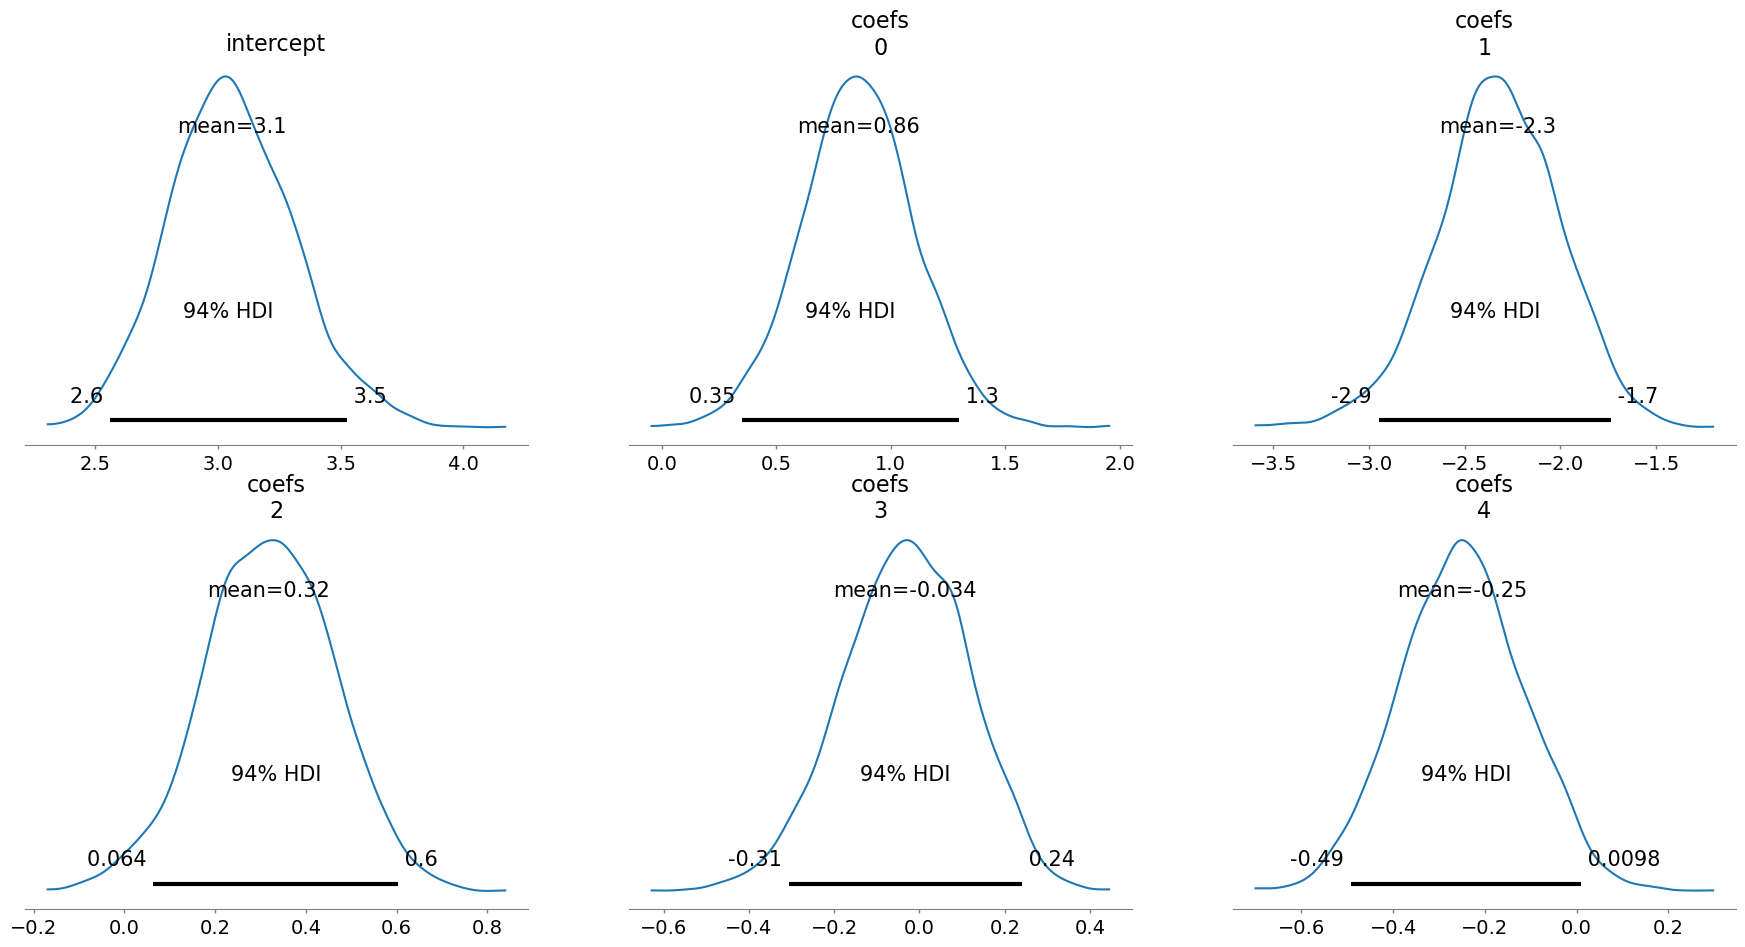

In [27]:
with pm.Model() as logistic_model:
    # Priors for coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coefs = pm.Normal('coefs', mu=0, sigma=10, shape=X_test_standardized.shape[1])
    
    # Linear combination
    logits = intercept + pm.math.dot(X_test_standardized.values, coefs)
    
    # Likelihood
    outcome = pm.Bernoulli('outcome', logit_p=logits, observed=y_test)
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

import arviz as az
az.summary(trace, hdi_prob=0.95)
az.plot_posterior(trace)

| Coef Index    | Mean       | 94% HDI          | Interpretation                                                            |
| ------------- | ---------- | ---------------- | ------------------------------------------------------------------------- |
| **Intercept** | **3.0**    | \[2.6, 3.5]      | Baseline log-odds when all features are zero (after standardization).     |
| **0**         | **0.85**   | \[0.4, 1.4]      | **Positive** effect — this feature increases success probability.         |
| **1**         | **-2.3**   | \[-2.9, -1.7]    | **Strong negative** effect — this feature **strongly reduces** success.   |
| **2**         | **0.32**   | \[0.05, 0.58]    | Weak but positive effect. The HDI mostly excludes 0, so likely real.      |
| **3**         | **-0.034** | \[-0.29, 0.26]   | Effect is **uncertain** — the HDI includes 0. Likely no strong influence. |
| **4**         | **-0.25**  | \[-0.51, \~0.00] | Mostly negative effect — a **possible** small negative influence.         |


| Feature          | 🇪🇸 Before Final (Mean, HDI) | 🏁 Final vs England (Mean, HDI) | Change & Interpretation                                                |
| ---------------- | ----------------------------- | ------------------------------- | ---------------------------------------------------------------------- |
| **Intercept**    | 2.8 \[2.7, 3.0]               | 3.0 \[2.6, 3.5]                 | Slight increase — overall pass success log-odds a bit higher.          |
| `box_start`      | 1.0 \[0.85, 1.2]              | 0.85 \[0.4, 1.4]                | Slight dip — starting position less predictive of success.             |
| `box_end`        | -2.0 \[-2.2, -1.8]            | -2.3 \[-2.9, -1.7]              | More negative — deeper ending passes were riskier vs England.          |
| `Normal Pass`    | \~0.03 \[-0.08, 0.14]         | 0.32 \[0.05, 0.58]              | Became **more effective** — normal passes contributed more to success. |
| `Leg Pass`       | 0.25 \[0.15, 0.36]            | -0.034 \[-0.29, 0.26]           | Lost effectiveness — no clear contribution in the final.               |
| `Under Pressure` | -0.35 \[-0.45, -0.25]         | -0.25 \[-0.51, \~0.00]          | Still negative, but weaker — Spain dealt better under pressure.        |
